# EPA1361 - Model-Based Decision Making

## Multi-model analysis

This exercise uses a simple version of the [Lotka-Volterra predator-prey equations](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations) to show how the EMA Workbench can be used for a
multi-model analysis, in addition to typical parametric/structural uncertainties. This will let you test the connectors provided in the Workbench for Excel, NetLogo, and Vensim / PySD; we'll also use the models for the sensitivity analysis exercise in week 3.

* Using the three model files provided and the Python function below, define model objects for each implementation (Excel, NetLogo, Vensim/PySD, and Python), and test them using a single ensemble. Use 50 experiments sampled from the parameters below (so that each experiment will be executed for the 4 models, for a total of 200), and retrieve outputs for the _TIME_, _predators_, and _prey_ variables.
    * excel and vensim are only supported on windows
    * vensim requires 32 bit python, and a 7.1!! version of vensim DSS
    * Netlogo supoprt depends on [jpype](http://jpype.readthedocs.io/en/latest/install.html) and [pynetlogo](https://pynetlogo.readthedocs.io/en/latest/). Also, if you don't have NetLogo installed, please get it from [NetLogo 6.0](https://ccl.northwestern.edu/netlogo/download.shtml) 
    * for pysd, see [its documentation](http://pysd.readthedocs.io/en/master/installation.html)
    * If possible try to work with all model versions, but even 2 or 3 (pure python and something else should be sufficient).
    

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |
|Final time	    |365	    |
|dt	    |0.25	    |

* Note that your EMA Workbench installation includes example scripts for the different connectors. The different model objects follow a similar syntax but will need to be slightly adjusted depending on the software (e.g. to specify the NetLogo run length or the sheet name in Excel). 

* These model objects can be used with a replication functionality (for instance to test the effect of stochastic uncertainty in a NetLogo model), which repeats a given experiment over multiple replications. You can use a single replication in this exercise as the models are not stochastic. By default, each outcome array will then have a shape of (# experiments, # replications, # time steps). Try adapting the outcome arrays so that they can be used with the _lines_ plotting function of the Workbench, and plot the results grouped by model.

* To check the graphical results, find the maximum absolute error of the time series you obtained for the _prey_ variable in the Excel, NetLogo, and Vensim/PySD models, relative to the Python function. 

In [29]:
import numpy as np
import matplotlib.pyplot as plt

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, perform_experiments,
                           ema_logging, MultiprocessingEvaluator)

from ema_workbench.connectors.netlogo import NetLogoModel
from ema_workbench.connectors.excel import ExcelModel
from ema_workbench.connectors.pysd_connector import PysdModel

from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS

from ema_workbench.analysis.plotting import lines, Density


def PredPrey(prey_birth_rate=0.025, predation_rate=0.0015, predator_efficiency=0.002,
             predator_loss_rate=0.06, initial_prey=50, initial_predators=20, dt=0.25, final_time=365, reps=1):

    #Initial values
    predators, prey, sim_time = [np.zeros((reps, int(final_time/dt)+1)) for _ in range(3)]
    
    for r in range(reps):
        predators[r,0] = initial_predators
        prey[r,0] = initial_prey

        #Calculate the time series
        for t in range(0, sim_time.shape[1]-1):

            dx = (prey_birth_rate*prey[r,t]) - (predation_rate*prey[r,t]*predators[r,t])
            dy = (predator_efficiency*predators[r,t]*prey[r,t]) - (predator_loss_rate*predators[r,t])

            prey[r,t+1] = max(prey[r,t] + dx*dt, 0)
            predators[r,t+1] = max(predators[r,t] + dy*dt, 0)
            sim_time[r,t+1] = (t+1)*dt
    
    #Return outcomes
    return {'TIME':sim_time,
            'predators':predators,
            'prey':prey}

In [34]:
ema_logging.log_to_stderr(ema_logging.INFO)

uncertainty = [RealParameter('prey_birth_rate', 0.015, 0.035),
               RealParameter('predation_rate', 0.0005, 0.003),
               RealParameter('predator_efficiency', 0.001, 0.004),
               RealParameter('predator_loss_rate', 0.04, 0.08)]

outcome = [TimeSeriesOutcome('TIME'),
           TimeSeriesOutcome('predators'),
           TimeSeriesOutcome('prey')]

python_model = Model('Python', function=PredPrey)
python_model.uncertainties = uncertainty
python_model.outcomes = outcome

vensim_model = PysdModel('Pysd', mdl_file='./model/PredPrey.mdl')
vensim_model.uncertainties = uncertainty
vensim_model.outcomes = outcome

excel_model = ExcelModel('Excel', wd='./model/', model_file='PredPrey.xlsx')
excel_model.default_sheet = 'Sheet1'
excel_model.uncertainties = uncertainty
excel_model.outcomes = outcome

netlogo_model = NetLogoModel('PredPrey', wd='./model/', model_file='PredPrey.nlogo')
netlogo_model.run_length = int(365 / 0.25)
netlogo_model.replications = 1
netlogo_model.uncertainties = uncertainty
netlogo_model.outcomes = outcome

In [36]:
results = perform_experiments([python_model, vensim_model, excel_model], 50)

[MainProcess/INFO] performing 50 scenarios * 1 policies * 3 model(s) = 150 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 15 cases completed
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 45 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 75 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] 105 cases completed
[MainProcess/INFO] 120 cases completed
[MainProcess/INFO] 135 cases completed
[MainProcess/INFO] 150 cases completed
[MainProcess/INFO] experiments finished


In [86]:
exp, out = results
print(exp.shape)
print(out['prey'].shape)

out_tuple = {key:out[key][:,0,:] for key in out.keys()}
print(out_tuple['TIME'].shape)
print(out_tuple['prey'].shape)

(150, 7)
(150, 1, 1461)
(150, 1461)
(150, 1461)


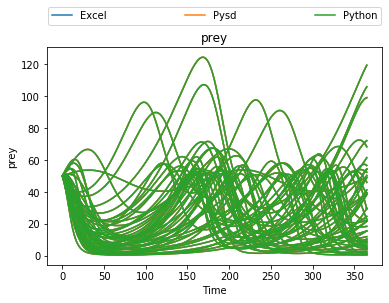

In [87]:
lines(exp, out_tuple, outcomes_to_show='prey', group_by='model')
      
plt.show()

In [92]:
exp

,predation_rate,predator_efficiency,predator_loss_rate,prey_birth_rate,scenario,policy,model
0,0.002287,0.001604,0.046874,0.020228,1400,None,Python
1,0.001355,0.002949,0.061776,0.028372,1401,None,Python
2,0.000966,0.001804,0.048058,0.017294,1402,None,Python
3,0.001432,0.003178,0.073502,0.029168,1403,None,Python
4,0.002586,0.003552,0.063716,0.026539,1404,None,Python
...,...,...,...,...,...,...,...
145,0.002095,0.001528,0.040662,0.033821,1445,None,Excel
146,0.001811,0.002180,0.076046,0.025168,1446,None,Excel
147,0.002459,0.001133,0.067375,0.028116,1447,None,Excel
148,0.000589,0.002493,0.070031,0.032689,1448,None,Excel


In [111]:
python_out = out['prey'][exp['model']=='Python']
excel_out = out['prey'][exp['model']=='Excel']
vensim_out = out['prey'][exp['model']=='Pysd']

print(np.max(abs(python_out - excel_out)))
print(np.max(abs(python_out - vensim_out)))

2.1316282072803006e-14
5.258016244624741e-13
